In [721]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import glob
import os
import numpy as np
import iris.coord_categorisation
import pandas as pd
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

In [722]:
yearsec=60.0*60.0-24.0

In [724]:
def model_names(directory):
	files = glob.glob(directory+'/*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models


def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_avg(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        print 'cube already has latitude bounds'
    try:
        cube.coord('longitude').guess_bounds()
    except:
        print 'cube already has longitude bounds'
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def avg_years(cube,start_yr,end_yr):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        print 'cube already has year dimension'
    loc = np.where((cube.coord('year').points >= start_yr) & (cube.coord('year').points <= end_yr))
    if len(loc[0]) > 0:
        return cube[loc].collapsed('time', iris.analysis.MEAN)
    else:
        cube=cube.collapsed('time', iris.analysis.MEAN)
        cube.data[:] = np.nan
        return cube

                   
def return_years(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        print 'cube already has year dimension'
    return cube.coord('year').points




def populate_dict(data_dict,directory,models,variable,run,test_value):
    lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
    for model in models:
        go_ahead = True
        print model
        exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
        if exists:
            cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
#             cube = cube.collapsed(['depth'],iris.analysis.MEAN)
            iris.coord_categorisation.add_year(cube, 'time', name='year')
            cube = cube.aggregated_by('year', iris.analysis.MEAN)
            test = cube.collapsed(['latitude','longitude','time'],iris.analysis.MEAN)
            if test_value:
                if test.data < 0.6e-9:
                    go_ahead=False
            if go_ahead:
                first_dim = cube.coord(dimensions=1).long_name #latitude
                if first_dim == 'latitude':
    #                 cube.coord(dimensions=1).rename('latitude')
    #                 cube.coord(dimensions=2).rename('longitude')
                    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
                    data_dict[run][variable][model] = {}
                    data_dict[run][variable][model]['timeseries'] = area_avg(cube)
                    data_dict[run][variable][model]['years'] = return_years(cube)
                    data_dict[run][variable][model]['first20'] = first_20_avg = avg_years(cube,2006,2026)
                    data_dict[run][variable][model]['last20'] = last_20_avg = avg_years(cube,2079,2099)
        else:
            print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict

In [725]:
directory = '/data/BatCaveNAS/ph290/noc_talk/regridded/'



In [726]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')

data_dict = {}




In [727]:
variable = 'fgco2'
run = 'rcp85'
data_dict[run] = {}
data_dict[run][variable] = {}

In [729]:
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

BNU-ESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CESM1-BGC
CMCC-CESM
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GFDL-ESM2G
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2G_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H-CC
GISS-E2-R-CC
HadGEM2-CC
HadGEM2-ES
IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM
/data/BatCaveNAS/ph290/noc_talk/regridded/MIROC-ESM_fgco2_rcp85_r1i1p1_regridded.nc does not exist
MIROC-ESM-CHEM
MPI-ESM-LR
MPI-ESM-MR
NorESM1-ME
bcc-csm1-1
bcc-csm1-1-m
inmcm4
cube already has year dimension
cube already has year dimension
cube already has year dimension


In [673]:
variable = 'fgco2'
run = 'rcp26'
data_dict[run] = {}
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

BNU-ESM
CESM1-BGC
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-BGC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CESM1-BGCfgco2
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-BGCfgco2_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CESM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CESM_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CESMfgco2
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CESMfgco2_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CNRM-CM5fgco2
/data/BatCaveNAS/ph290/noc_talk/regridded/CNRM-CM5fgco2_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2fgco2
/data/BatCaveNAS/ph290/noc_talk/regridded/CanESM2fgco2_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GFDL-ESM2G
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2G_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GFDL-ESM2Mfgco2
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2Mfgco2_fgco2_rcp26_r1i

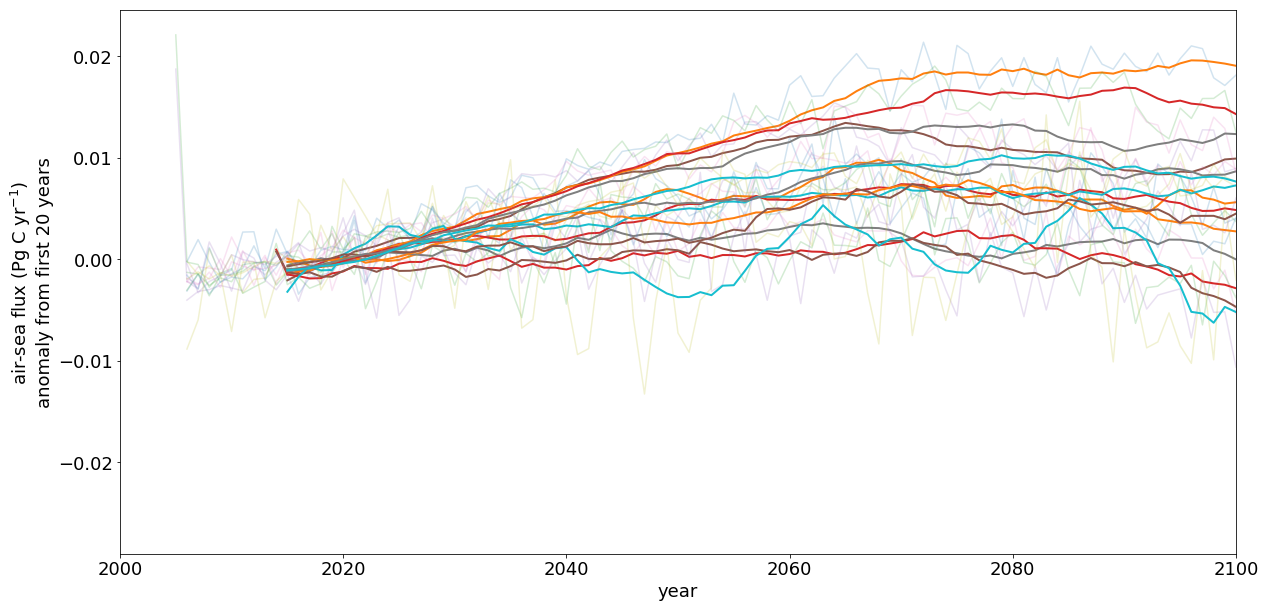

In [686]:
variable = 'fgco2'
run = 'rcp85'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
for model in list(data_dict[run][variable]):
    df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
    plt.plot(data_dict[run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),alpha=0.2,label=model)
    plt.plot(data_dict[run][variable][model]['years'],df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2000,2100])
# plt.legend(loc=1)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.show()



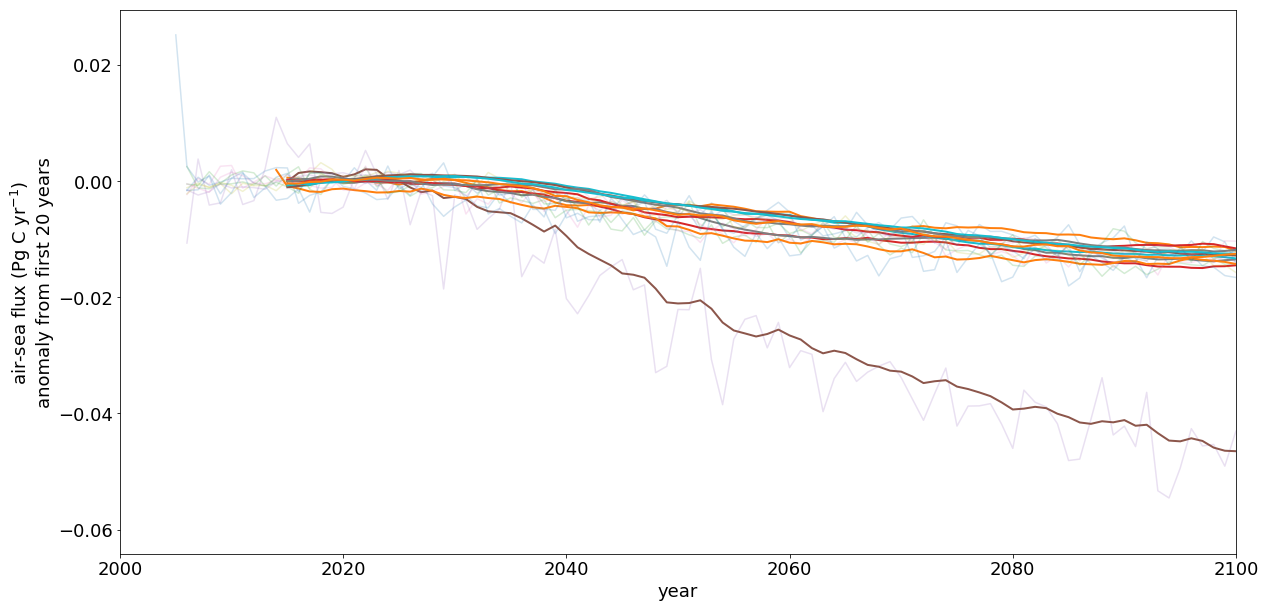

In [687]:
variable = 'fgco2'
run = 'rcp26'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
for model in list(data_dict[run][variable]):
    df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
    plt.plot(data_dict[run][variable][model]['years'],df.tmp-df.tmp[0:20].mean(),alpha=0.2,label=model)
    plt.plot(data_dict[run][variable][model]['years'],df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2000,2100])
# plt.legend(loc=1)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.show()

In [599]:
def calculate_agreement(run_composites,agreement):
    # run_composites=run_composites[lag]
    composites_agreement = run_composites[0].copy()
    composites_agreement[:] = 0.0
    for i in range(np.shape(run_composites)[1]):
        for j in range(np.shape(run_composites)[2]):
            tmp1 = run_composites[:,i,j]
            a = np.float(len(np.where(tmp1 > 0.0)[0]))
            b = np.float(len(np.where(tmp1 < 0.0)[0]))
            ratio = np.max([a/len(tmp1),b/len(tmp1)])
            # if b > 0.0:
            #     ratio = (a / b)
            #     # print 'ratio ',ratio
            if ratio > agreement:
                composites_agreement[i,j] = np.NAN
            if run_composites[:,i,j].all() == 0.0:
            	composites_agreement[i,j] = np.NAN
    return composites_agreement

In [684]:
variable = 'fgco2'
run = 'rcp85'
models = list(data_dict[run][variable])
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data


diff = last_period-first_period

diff_mean = np.mean(diff,axis=0)

tmp_cube = data_dict[run][variable][model]['first20']
tmp_cube.data = diff_mean
agreement = 0.66
agreement_map = calculate_agreement(diff,agreement)

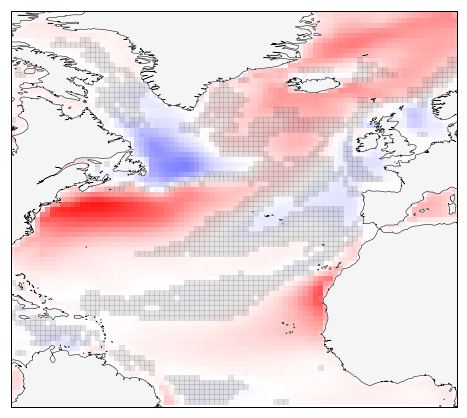

In [688]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')

my_projection = ccrs.PlateCarree()
my_extent = [-80.0,10,0.0,80.0]

plt.close('all')
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = tmp_cube.coord('latitude').points
lons1 = tmp_cube.coord('longitude').points
data1 = tmp_cube.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax1.pcolormesh(lons1, lats1, agreement_map,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)



Multi model mean change in update last 20 years - first 20 yeats 
greyed is where fewer than 66% of models agree on the sign of change

In [730]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')
models.remove('MIROC-ESM-CHEM')
models.remove('GFDL-ESM2G')
models.remove('MIROC-ESM')

variable = 'talk'
run = 'rcp85'
data_dict[run] = {}
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

BNU-ESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CESM1-BGC
cube already has year dimension
cube already has year dimension
cube already has year dimension
CMCC-CESM
cube already has year dimension
cube already has year dimension
cube already has year dimension
CanESM2
cube already has year dimension
cube already has year dimension
cube already has year dimension
GISS-E2-H-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H-CC_talk_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-R-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-R-CC_talk_rcp85_r1i1p1_regridded.nc does not exist
HadGEM2-CC
cube already has year dimension
cube already has year dimension
cube already has year dimension
HadGEM2-ES
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-LR
cube already has year dimension
cube already has year dimension
cube already has year dimension
IPSL-CM5A-MR
cube already has

In [731]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube = data_dict[run][variable][model]['first20']
tmp_cube.data = first_period_mean
agreement = 0.66
agreement_map = calculate_agreement(first_period,agreement)

['IPSL-CM5A-LR', 'MPI-ESM-LR', 'CanESM2', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'IPSL-CM5A-MR', 'CESM1-BGC']


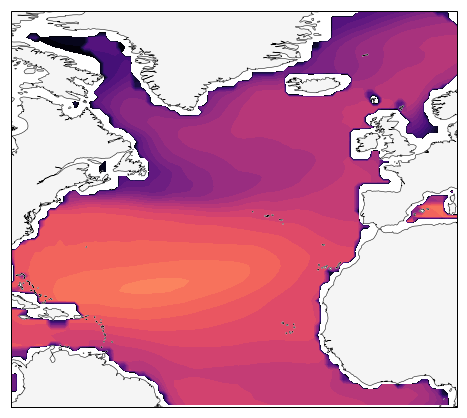

In [740]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')

my_projection = ccrs.PlateCarree()
my_extent = [-80.0,10,0.0,80.0]

plt.close('all')
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = tmp_cube.coord('latitude').points
lons1 = tmp_cube.coord('longitude').points
data1 = tmp_cube.data


contour_result1 = ax1.contourf(lons1, lats1, data1,np.linspace(2.0,2.8,30),
			transform=ccrs.PlateCarree(),cmap='magma')
contour_result2 = ax1.pcolormesh(lons1, lats1, agreement_map,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

